In [32]:
import gymnasium as gym
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Categorical
import warnings
import gc
import os
from typing import List, Tuple, Optional, Dict
import logging
from collections import deque
import math
from scipy.optimize import minimize
from datetime import datetime

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)

In [33]:
SELECTED_TICKERS = [
    'AAPL',     
    'MSFT',    
    'JPM',      
    'GOOGL',    
    'AMZN',     
    'JNJ',      
    'XOM',      
    'PG',      
    'VZ',       
    'CAT'      
]

BENCHMARK_INDEX = '^GSPC' 

START_DATE = "2010-01-01"
END_DATE = "2024-01-01"

In [34]:
torch.backends.mps.max_memory_fraction = 0.7
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [35]:
def detect_market(benchmark_index: str, tickers: List[str]) -> Dict[str, str]:
    market_info = {"name": "Custom Market", "currency": "$", "region": "Unknown"}
    
    benchmark_map = {
        '^NSEI': {"name": "NIFTY 50", "currency": "₹", "region": "India"},
        '^SPX': {"name": "S&P 500", "currency": "$", "region": "US"},
        '^GSPC': {"name": "S&P 500", "currency": "$", "region": "US"},
        '^DJI': {"name": "Dow Jones", "currency": "$", "region": "US"},
        '^IXIC': {"name": "NASDAQ", "currency": "$", "region": "US"},
        '^STOXX50E': {"name": "Euro Stoxx 50", "currency": "€", "region": "Europe"},
        '^FTSE': {"name": "FTSE 100", "currency": "£", "region": "UK"},
        '^N225': {"name": "Nikkei 225", "currency": "¥", "region": "Japan"},
        '^HSI': {"name": "Hang Seng", "currency": "HK$", "region": "Hong Kong"},
        '^AXJO': {"name": "ASX 200", "currency": "A$", "region": "Australia"},
    }
    
    if benchmark_index in benchmark_map:
        market_info.update(benchmark_map[benchmark_index])
    else:
        if any(ticker.endswith('.NS') for ticker in tickers):
            market_info = {"name": "Indian Market", "currency": "₹", "region": "India"}
        elif any(ticker.endswith('.L') for ticker in tickers):
            market_info = {"name": "UK Market", "currency": "£", "region": "UK"}
        elif any(ticker.endswith('.T') for ticker in tickers):
            market_info = {"name": "Japanese Market", "currency": "¥", "region": "Japan"}
        elif any(ticker.endswith('.AS') or ticker.endswith('.PA') or ticker.endswith('.DE') for ticker in tickers):
            market_info = {"name": "European Market", "currency": "€", "region": "Europe"}
    
    return market_info

In [36]:
class Config:
    MAX_DATA_POINTS = 10000
    DDPM_SEQ_LENGTH = 16
    DDPM_BATCH_SIZE = 8
    DDPM_EPOCHS = 10
    DDPM_CHANNELS = [16, 32, 64]
    DDPM_TIMESTEPS = 500
    DDPM_BETA_SCHEDULE = 'cosine'
    RL_WINDOW = 15
    RL_EPISODES = 20
    PPO_EPOCHS = 3
    PPO_CLIP = 0.2
    PPO_LR = 2e-4
    
    MAX_POSITION_SIZE = 0.25      
    MIN_POSITION_SIZE = 0.03      
    REBALANCE_THRESHOLD = 0.025   
    MIN_DAYS_BETWEEN_REBALANCE = 2  
    MAX_DAYS_WITHOUT_REBALANCE = 20  
    
    @staticmethod
    def get_device():
        if torch.backends.mps.is_available():
            print("Using Apple Silicon MPS")
            return torch.device("mps")
        elif torch.backends.cuda.is_available():
            print("Using CUDA")
            return torch.device("cuda")
        else:
            print("Using CPU")
            return torch.device("cpu")

class MemoryManager:
    @staticmethod
    def clear_memory():
        gc.collect()
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()
    
    @staticmethod
    def get_memory_usage():
        import psutil
        memory = psutil.virtual_memory()
        return f"Memory: {memory.percent:.1f}% used ({memory.used // 1024**3:.1f}GB / {memory.total // 1024**3:.1f}GB)"


In [37]:
class SinusoidalPositionalEmbedding(nn.Module):
    """Sinusoidal positional embedding for time steps"""
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [38]:
class ResidualBlock(nn.Module):
    """Residual block for DDPM U-Net"""
    
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        # Adjust group norm groups based on channel count
        groups = min(8, in_channels) if in_channels >= 8 else 1
        
        self.block1 = nn.Sequential(
            nn.GroupNorm(groups, in_channels),
            nn.SiLU(),
            nn.Conv1d(in_channels, out_channels, 3, padding=1)
        )
        
        # Adjust group norm for output channels
        out_groups = min(8, out_channels) if out_channels >= 8 else 1
        
        self.block2 = nn.Sequential(
            nn.GroupNorm(out_groups, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, 3, padding=1)
        )
        
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, time_emb):
        h = self.block1(x)
        
        # Add time embedding
        time_emb = self.time_mlp(time_emb)
        h = h + time_emb[..., None]
        
        h = self.block2(h)
        return h + self.residual_conv(x)

In [50]:
class DDPM(nn.Module):    
    def __init__(self, n_assets, seq_length, market_info, device='cpu'):
        super().__init__()
        self.n_assets = n_assets
        self.seq_length = seq_length
        self.timesteps = 200
        self.device = device
        self.market_info = market_info
        
        hidden_dim = 128
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionalEmbedding(32),
            nn.Linear(32, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Market condition embedding
        self.market_embed = nn.Sequential(
            nn.Linear(4, 64),
            nn.SiLU(),
            nn.Linear(64, hidden_dim)
        )
        
        # Main network 
        self.net = nn.Sequential(
            nn.Linear(n_assets * seq_length + hidden_dim, hidden_dim * 2),
            nn.SiLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.SiLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, n_assets * seq_length)
        )
        
        # Noise schedule
        self.register_buffer('betas', self._get_beta_schedule())
        self.register_buffer('alphas', 1 - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - self.alphas_cumprod))
        
        # Market-specific scaling
        self.volatility_scale = self._get_market_volatility_scale()
        
        print(f"   Simple Financial DDPM initialized for {market_info['region']} markets")
        print(f"   Assets: {n_assets}, Sequence: {seq_length}")
        print(f"   Timesteps: {self.timesteps}")
        print(f"   Volatility scaling: {self.volatility_scale:.3f}")
    
    def _get_beta_schedule(self):
        return torch.linspace(0.0001, 0.02, self.timesteps)
    
    def _get_market_volatility_scale(self):
        scale_map = {
            "India": 1.2, 
            "US": 1.0, 
            "Europe": 0.9, 
            "UK": 0.9, 
            "Japan": 0.8, 
            "Unknown": 1.1
        }
        return scale_map.get(self.market_info['region'], 1.0)
    
    def forward(self, x, t, market_condition=None):
        batch_size = x.size(0)
        
        x_flat = x.view(batch_size, -1)
        time_emb = self.time_embed(t)
        
        # Add market condition 
        if market_condition is not None:
            market_emb = self.market_embed(market_condition)
            time_emb = time_emb + market_emb

        combined = torch.cat([x_flat, time_emb], dim=1)
        
        output_flat = self.net(combined)
        output = output_flat.view(batch_size, self.n_assets, self.seq_length)
        
        return output
    
    def add_noise(self, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x) * self.volatility_scale
        
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1)
        
        return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise
    
    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device)
    
    def denoise_step(self, x_t, t, model_output, market_condition=None):
        alpha_t = self.alphas[t].view(-1, 1, 1)
        alpha_cumprod_t = self.alphas_cumprod[t].view(-1, 1, 1)
        alpha_cumprod_prev = self.alphas_cumprod[t-1] if t > 0 else torch.ones_like(alpha_cumprod_t)
        alpha_cumprod_prev = alpha_cumprod_prev.view(-1, 1, 1)
        
        # Predicted original sample
        pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod_t) * model_output) / torch.sqrt(alpha_cumprod_t)
        
        posterior_mean = (
            torch.sqrt(alpha_cumprod_prev) * self.betas[t].view(-1, 1, 1) * pred_x0 +
            torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev) * x_t
        ) / (1 - alpha_cumprod_t)
        
        if t == 0:
            return posterior_mean
        else:
            posterior_variance = self.betas[t] * (1 - alpha_cumprod_prev) / (1 - alpha_cumprod_t)
            noise = torch.randn_like(x_t) * self.volatility_scale
            return posterior_mean + torch.sqrt(posterior_variance.view(-1, 1, 1)) * noise

In [51]:
class DDPMTrainer:    
    def __init__(self, model, device, learning_rate=1e-4):
        self.model = model
        self.device = device
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100)
        self.loss_history = []
        
    def train_step(self, batch, market_conditions=None):
        self.model.train()
        x = batch.to(self.device)
        batch_size = x.size(0)
        
        try:
            t = self.model.sample_timesteps(batch_size)
            
            noise = torch.randn_like(x) * self.model.volatility_scale
            x_noisy = self.model.add_noise(x, t, noise)
            
            # Predict noise
            if market_conditions is not None:
                market_conditions = market_conditions.to(self.device)
            
            predicted_noise = self.model(x_noisy, t, market_conditions)
            
            base_loss = F.mse_loss(predicted_noise, noise, reduction='none')
            
            # Weight loss
            weights = 1.0 + 0.5 * torch.abs(x).mean(dim=-1, keepdim=True)
            weighted_loss = (base_loss * weights).mean()
            
            self.optimizer.zero_grad()
            weighted_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            return weighted_loss.item()
            
        except Exception as e:
            print(f"   DDPM training step failed: {e}")
            print(f"   Batch shape: {x.shape}")
            if market_conditions is not None:
                print(f"   Market conditions shape: {market_conditions.shape}")
            raise e
    
    def train_epoch(self, dataloader, market_conditions=None):
        total_loss = 0
        num_batches = 0
        
        for batch in dataloader:
            batch_market_conditions = None
            if market_conditions is not None:
                batch_market_conditions = market_conditions[num_batches:num_batches+len(batch)]
            
            loss = self.train_step(batch, batch_market_conditions)
            total_loss += loss
            num_batches += 1
        
        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        self.loss_history.append(avg_loss)
        self.scheduler.step()
        return avg_loss

In [ ]:
class DataGenerator:    
    def __init__(self, ddpm_model, device, market_info):
        self.model = ddpm_model
        self.device = device
        self.market_info = market_info
        
    def generate_sequences(self, num_sequences, market_conditions=None, guidance_scale=1.0):
        self.model.eval()
        
        with torch.no_grad():
            shape = (num_sequences, self.model.n_assets, self.model.seq_length)
            x = torch.randn(shape, device=self.device) * self.model.volatility_scale
            
            if market_conditions is not None:
                market_conditions = market_conditions.to(self.device)
                if market_conditions.size(0) != num_sequences:
                    market_conditions = market_conditions.repeat(num_sequences, 1)
            
            for t in reversed(range(self.model.timesteps)):
                t_tensor = torch.full((num_sequences,), t, device=self.device, dtype=torch.long)
                
                predicted_noise = self.model(x, t_tensor, market_conditions)
                
                if guidance_scale != 1.0 and market_conditions is not None:
                    try:
                        uncond_noise = self.model(x, t_tensor, None)
                        predicted_noise = uncond_noise + guidance_scale * (predicted_noise - uncond_noise)
                    except:
                        pass
                
                x = self.model.denoise_step(x, t, predicted_noise, market_conditions)
        
        return x.cpu()

In [40]:
class RegimeDetector:    
    def __init__(self, market_info: Dict[str, str], lookback_period: int = 60):
        self.lookback_period = lookback_period
        self.regime_history = deque(maxlen=252)
        self.market_info = market_info
        
        self.volatility_multiplier = self._get_volatility_multiplier()
        self.return_multiplier = self._get_return_multiplier()
        
        base_daily_return = 0.0008
        base_volatility = 0.025
        
        self.bull_thresholds = {
            'min_return': base_daily_return * self.return_multiplier,
            'max_volatility': base_volatility * self.volatility_multiplier,
            'min_trend_strength': 0.55
        }
        
        self.bear_thresholds = {
            'max_return': -base_daily_return * self.return_multiplier,
            'min_volatility': base_volatility * 0.8 * self.volatility_multiplier,
            'max_trend_strength': 0.45
        }
        
        self.volatile_threshold = base_volatility * 1.4 * self.volatility_multiplier
        
        print(f"  {self.market_info['region']} Market Regime Detector initialized")
        print(f"   Volatility multiplier: {self.volatility_multiplier:.2f}")
        print(f"   Return multiplier: {self.return_multiplier:.2f}")
    
    def _get_volatility_multiplier(self) -> float:
        """Adjust volatility expectations by market"""
        region_multipliers = {
            "India": 1.2, 
            "US": 1.0, 
            "Europe": 0.9, 
            "UK": 0.95, 
            "Japan": 0.85, 
            "Unknown": 1.0
        }
        return region_multipliers.get(self.market_info['region'], 1.0)
    
    def _get_return_multiplier(self) -> float:
        """Adjust return expectations by market"""
        region_multipliers = {
            "India": 1.1, 
            "US": 1.0, 
            "Europe": 0.9, 
            "UK": 0.9, 
            "Japan": 0.8, 
            "Unknown": 1.0
        }
        return region_multipliers.get(self.market_info['region'], 1.0)
    
    def detect_current_regime(self, returns: pd.Series) -> Dict[str, float]:
        if len(returns) < self.lookback_period:
            return {
                'regime': 'sideways',
                'confidence': 0.5, 
                'bull_prob': 0.25, 
                'bear_prob': 0.25,
                'sideways_prob': 0.25, 
                'volatile_prob': 0.25
            }
        
        recent_returns = returns.tail(self.lookback_period)
        
        avg_return = recent_returns.mean()
        volatility = recent_returns.std()
        trend_strength = (recent_returns > 0).mean()
        
        bull_score = 0
        if avg_return > self.bull_thresholds['min_return']:
            bull_score += 0.4
        if volatility < self.bull_thresholds['max_volatility']:
            bull_score += 0.3
        if trend_strength > self.bull_thresholds['min_trend_strength']:
            bull_score += 0.3
        
        bear_score = 0
        if avg_return < self.bear_thresholds['max_return']:
            bear_score += 0.4
        if volatility > self.bear_thresholds['min_volatility']:
            bear_score += 0.3
        if trend_strength < self.bear_thresholds['max_trend_strength']:
            bear_score += 0.3
        
        volatile_score = 0
        if volatility > self.volatile_threshold:
            volatile_score += 0.6
        if abs(avg_return) < 0.0005:
            volatile_score += 0.4
        
        sideways_score = max(0, 1 - bull_score - bear_score - volatile_score)
        
        # Normalize scores
        total_score = bull_score + bear_score + volatile_score + sideways_score + 1e-8
        probs = {
            'bull_prob': bull_score / total_score,
            'bear_prob': bear_score / total_score,
            'volatile_prob': volatile_score / total_score,
            'sideways_prob': sideways_score / total_score
        }
        
        regime = max(probs.keys(), key=lambda k: probs[k]).replace('_prob', '')
        confidence = probs[f'{regime}_prob']
        
        result = {
            'regime': regime, 
            'confidence': confidence, 
            'avg_return': avg_return,
            'volatility': volatility, 
            'trend_strength': trend_strength, **probs
        }
        
        self.regime_history.append(result)
        return result
    
    def get_regime_risk_factor(self, regime_info: Dict) -> float:
        regime = regime_info['regime']
        confidence = regime_info['confidence']
        
        risk_factors = {
            'bull': 1.25, 
            'bear': 0.75, 
            'sideways': 0.9, 
            'volatile': 0.65
        }
        
        if self.market_info['region'] in ['India', 'Unknown']:
            risk_factors = {k: v * 0.9 for k, v in risk_factors.items()}
        
        base_factor = risk_factors.get(regime, 1.0)
        confidence_adjusted = 1.0 + (base_factor - 1.0) * confidence
        return np.clip(confidence_adjusted, 0.5, 1.5)

In [41]:
class Kelly:
    def __init__(self, market_info: Dict[str, str], lookback_period: int = 252, min_trades: int = 30):
        self.lookback_period = lookback_period
        self.min_trades = min_trades
        self.performance_history = deque(maxlen=self.lookback_period)
        self.market_info = market_info
        
        self.kelly_fraction = self._get_kelly_fraction()
        
        print(f"   Enhanced Kelly Position Sizer for {market_info['region']} markets")
        print(f"   Kelly fraction: {self.kelly_fraction:.1%}")
        print(f"   Lookback period: {lookback_period} days")
    
    def _get_kelly_fraction(self) -> float:
        region_fractions = {
            "India": 0.25, 
            "US": 0.35, 
            "Europe": 0.30, 
            "UK": 0.30, 
            "Japan": 0.25, 
            "Unknown": 0.20
        }
        return region_fractions.get(self.market_info['region'], 0.25)
    
    def calculate_enhanced_kelly_fractions(self, returns_data: pd.DataFrame, current_allocations: np.ndarray) -> np.ndarray:
        """Enhanced Kelly calculation with multi-timeframe analysis"""
        n_assets = len(current_allocations)
        kelly_fractions = np.zeros(n_assets)
        
        # Conservative default allocation
        default_allocation = 0.8 / n_assets
        
        for i, asset in enumerate(returns_data.columns):
            asset_returns = returns_data[asset].dropna()
            
            if len(asset_returns) < self.min_trades:
                kelly_fractions[i] = default_allocation
                continue
            
            # Multi-timeframe Kelly calculation
            short_term_kelly = self._calculate_kelly_for_period(asset_returns.tail(30))
            medium_term_kelly = self._calculate_kelly_for_period(asset_returns.tail(63))
            long_term_kelly = self._calculate_kelly_for_period(asset_returns.tail(126))
            
            # Weighted average 
            combined_kelly = 0.5 * short_term_kelly + 0.3 * medium_term_kelly + 0.2 * long_term_kelly
            
            # Apply Kelly fraction
            combined_kelly = combined_kelly * self.kelly_fraction
            kelly_fractions[i] = np.clip(combined_kelly, 0.05, 0.4)
        
        total = np.sum(kelly_fractions)
        if total > 0:
            kelly_fractions = kelly_fractions / total
        else:
            kelly_fractions = np.ones(n_assets) / n_assets
        
        return kelly_fractions
    
    def _calculate_kelly_for_period(self, returns: pd.Series) -> float:
        if len(returns) < 10:
            return 0.1
        
        positive_returns = returns[returns > 0]
        negative_returns = returns[returns < 0]
        
        if len(positive_returns) == 0 or len(negative_returns) == 0:
            return 0.1
        
        win_rate = len(positive_returns) / len(returns)
        avg_win = positive_returns.mean()
        avg_loss = abs(negative_returns.mean())
        
        if avg_loss > 0:
            b = avg_win / avg_loss
            p = win_rate
            q = 1 - p
            kelly_f = (b * p - q) / b
            return max(0, kelly_f)
        else:
            return 0.1
    
    def optimize_allocation_with_constraints(self, base_allocation: np.ndarray, kelly_fractions: np.ndarray, 
                                           regime_risk_factor: float, max_position: float = 0.15) -> np.ndarray:
        kelly_weight = 0.3
        combined_allocation = (kelly_weight * kelly_fractions + 
                             (1 - kelly_weight) * base_allocation)
        adjusted_allocation = combined_allocation * regime_risk_factor
        adjusted_allocation = np.clip(adjusted_allocation, 0.05, max_position)
        
        return adjusted_allocation / np.sum(adjusted_allocation)

In [42]:
class MarketTiming:
    """Market timing class for regime-aware allocation"""
    def __init__(self, market_info: Dict[str, str]):
        self.market_info = market_info
        self.volatility_threshold = 0.25
        
        print(f"  Market Timing Layer for {market_info['region']} markets")
    
    def get_market_exposure(self, current_regime: Dict, market_volatility: float) -> float:
        base_exposure = 1.0

        if current_regime['bull_prob'] > 0.7:
            base_exposure *= 1.4 
        elif current_regime['bull_prob'] > 0.6:
            base_exposure *= 1.25
        elif current_regime['bear_prob'] > 0.8:
            base_exposure *= 0.85
        elif current_regime['volatile_prob'] > 0.6:
            base_exposure *= 0.9

        if market_volatility > self.volatility_threshold:
            vol_reduction = min(0.25, (market_volatility - self.volatility_threshold) * 1.5)
            base_exposure *= (1 - vol_reduction)

        return np.clip(base_exposure, 0.8, 1.5)

    def apply_market_timing(self, base_allocation: np.ndarray, market_exposure: float) -> Tuple[np.ndarray, float]:
        scaled_allocation = base_allocation * market_exposure
        cash_allocation = 1.0 - np.sum(scaled_allocation)
        
        return scaled_allocation, max(0, cash_allocation)

In [43]:
class FeatureCalculator:
    def __init__(self, market_info: Dict[str, str], min_periods: int = 30):
        self.min_periods = min_periods
        self.market_info = market_info
        self.regime_detector = RegimeDetector(market_info)
        
        print(f"  Enhanced Feature Calculator for {market_info['region']} markets")
    
    def calculate_enhanced_features(self, data: pd.DataFrame, end_idx: int) -> pd.Series:
        if end_idx < self.min_periods:
            return self._get_default_features(data)
        
        historical_data = data.iloc[max(0, end_idx - 100):end_idx + 1]
        features = {}
        all_returns = []
        
        # Asset-specific features with multiple timeframes
        for col in data.columns:
            col_data = historical_data[col]
            col_returns = col_data.pct_change().dropna()
            all_returns.append(col_returns)
            
            # Multi-timeframe momentum
            features[f'{col}_momentum_5d'] = self.calculate_momentum(col_data, 5)
            features[f'{col}_momentum_10d'] = self.calculate_momentum(col_data, 10)
            features[f'{col}_momentum_20d'] = self.calculate_momentum(col_data, 20)
            
            # Multi-timeframe volatility
            features[f'{col}_vol_5d'] = self.calculate_volatility(col_returns, 5)
            features[f'{col}_vol_20d'] = self.calculate_volatility(col_returns, 20)
            
            # Technical indicators
            features[f'{col}_rsi'] = (self.calculate_rsi(col_data) - 50) / 50
            features[f'{col}_sma_ratio'] = self.calculate_sma_ratio(col_data, 20)
            
            # Trend strength
            features[f'{col}_trend_strength'] = self.calculate_trend_strength(col_data, 20)
        
        if all_returns and len(all_returns[0]) > 0:
            market_returns = pd.concat(all_returns, axis=1).mean(axis=1)
            
            # Multi-timeframe market features
            features['market_momentum_5d'] = market_returns.tail(5).mean() if len(market_returns) >= 5 else 0
            features['market_momentum_20d'] = market_returns.tail(20).mean() if len(market_returns) >= 20 else 0
            
            features['market_vol_5d'] = market_returns.tail(5).std() if len(market_returns) >= 5 else 0.02
            features['market_vol_20d'] = market_returns.tail(20).std() if len(market_returns) >= 20 else 0.02
            
            # Correlation analysis
            features.update(self._calculate_correlation_features(all_returns))
            
            # Regime detection
            regime_info = self.regime_detector.detect_current_regime(market_returns)
            features.update({
                'bull_prob': regime_info['bull_prob'],
                'bear_prob': regime_info['bear_prob'],
                'sideways_prob': regime_info['sideways_prob'],
                'volatile_prob': regime_info['volatile_prob'],
                'regime_risk_factor': self.regime_detector.get_regime_risk_factor(regime_info)
            })
        else:
            features.update(self._get_default_market_features())
        
        return pd.Series(features).fillna(0.0)
    
    def _calculate_correlation_features(self, all_returns: List[pd.Series]) -> Dict[str, float]:
        if len(all_returns) <= 1:
            return {'correlation_avg': 0.0, 'correlation_max': 0.0, 'correlation_dispersion': 0.0}
        
        returns_df = pd.concat(all_returns, axis=1)
        if len(returns_df) < 10:
            return {'correlation_avg': 0.0, 'correlation_max': 0.0, 'correlation_dispersion': 0.0}
        
        corr_matrix = returns_df.tail(30).corr()
        mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
        correlations = corr_matrix.values[mask]
        
        return {
            'correlation_avg': np.mean(correlations),
            'correlation_max': np.max(correlations),
            'correlation_dispersion': np.std(correlations)
        }
    
    def calculate_momentum(self, prices: pd.Series, period: int = 10) -> float:
        if len(prices) < period:
            return 0.0
        return (prices.iloc[-1] / prices.iloc[-period] - 1)
    
    def calculate_volatility(self, returns: pd.Series, period: int = 20) -> float:
        if len(returns) < period:
            return 0.02
        return returns.tail(period).std()
    
    def calculate_rsi(self, prices: pd.Series, period: int = 14) -> float:
        if len(prices) < period + 1:
            return 50.0
        
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        
        rs = gain / (loss + 1e-8)
        rsi = 100 - (100 / (1 + rs))
        return rsi.iloc[-1] if not pd.isna(rsi.iloc[-1]) else 50.0
    
    def calculate_sma_ratio(self, prices: pd.Series, period: int = 20) -> float:
        if len(prices) < period:
            return 0.0
        sma = prices.tail(period).mean()
        return (prices.iloc[-1] / sma - 1) if sma > 0 else 0
    
    def calculate_trend_strength(self, prices: pd.Series, period: int = 20) -> float:
        if len(prices) < period:
            return 0.0
        returns = prices.pct_change().dropna().tail(period)
        return (returns > 0).mean() - 0.5  # Centered around 0
    
    def _get_default_features(self, data: pd.DataFrame) -> pd.Series:
        n_assets = len(data.columns)
        feature_names = []
        for col in data.columns:
            feature_names.extend([
                f'{col}_momentum_5d', f'{col}_momentum_10d', f'{col}_momentum_20d',
                f'{col}_vol_5d', f'{col}_vol_20d', f'{col}_rsi', f'{col}_sma_ratio', f'{col}_trend_strength'
            ])
        feature_names.extend([
            'market_momentum_5d', 'market_momentum_20d', 'market_vol_5d', 'market_vol_20d',
            'correlation_avg', 'correlation_max', 'correlation_dispersion',
            'bull_prob', 'bear_prob', 'sideways_prob', 'volatile_prob', 'regime_risk_factor'
        ])
        return pd.Series(0.0, index=feature_names)
    
    def _get_default_market_features(self) -> Dict[str, float]:
        return {
            'market_momentum_5d': 0, 'market_momentum_20d': 0,
            'market_vol_5d': 0.02, 'market_vol_20d': 0.02,
            'correlation_avg': 0, 'correlation_max': 0, 'correlation_dispersion': 0,
            'bull_prob': 0.25, 'bear_prob': 0.25, 'sideways_prob': 0.25, 'volatile_prob': 0.25,
            'regime_risk_factor': 1.0
        }

In [44]:
class DataProcessor:
    def __init__(self, market_info: Dict[str, str]):
        self.config = Config()
        self.market_info = market_info
        self.feature_calculator = FeatureCalculator(market_info)
        self.ddpm = None
        self.ddpm_trainer = None
        self.data_generator = None
    
    def download_universal_data(self, tickers: List[str], benchmark: str, 
                               start: str = "2022-01-01", end: str = "2024-01-01"):
        """Universal data downloader for any market"""
        print(f"   Downloading {self.market_info['region']} market data")
        print(f"   Selected stocks: {len(tickers)} assets")
        print(f"   Benchmark: {benchmark} ({self.market_info['name']})")
        print(f"   Currency: {self.market_info['currency']}")
        print(MemoryManager.get_memory_usage())
        
        try:
            print(f"Downloading stock data...")
            data = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
            
            if isinstance(data, pd.Series):
                data = data.to_frame()
                
            print(f"Downloading benchmark ({benchmark})...")
            benchmark_data = yf.download(benchmark, start=start, end=end, auto_adjust=True)["Close"]
            
            if len(data) > self.config.MAX_DATA_POINTS:
                data = data.tail(self.config.MAX_DATA_POINTS)
                benchmark_data = benchmark_data.tail(self.config.MAX_DATA_POINTS)
                print(f"Limited to last {self.config.MAX_DATA_POINTS} data points")
            
            data = data.ffill().bfill().dropna()
            benchmark_data = benchmark_data.ffill().bfill()
            
            # Align dates
            common_dates = data.index.intersection(benchmark_data.index)
            data = data.loc[common_dates]
            benchmark_data = benchmark_data.loc[common_dates]
            
            print(f" Stock data shape: {data.shape}")
            print(f" Benchmark data shape: {benchmark_data.shape}")
            
            print(f" Recent Performance (20-day):")
            for ticker in tickers:
                if ticker in data.columns and len(data) >= 21:
                    recent_return = (data[ticker].iloc[-1] / data[ticker].iloc[-21] - 1) * 100
                    clean_name = ticker.replace('.NS', '').replace('.L', '').replace('.T', '').replace('.AS', '').replace('.PA', '').replace('.DE', '')
                    print(f"   {clean_name}: {recent_return:+.1f}%")
            
            if len(benchmark_data) >= 21:
                if isinstance(benchmark_data, pd.DataFrame):
                    benchmark_col = benchmark_data.columns[0]
                    benchmark_return = (benchmark_data[benchmark_col].iloc[-1] / benchmark_data[benchmark_col].iloc[-21] - 1) * 100
                else:
                    benchmark_return = (benchmark_data.iloc[-1] / benchmark_data.iloc[-21] - 1) * 100
                print(f"   {self.market_info['name']}: {benchmark_return:+.1f}%")
            
            return data, benchmark_data
            
        except Exception as e:
            print(f" Error downloading data: {e}")
            raise
    
    def prepare_ddpm_training_data(self, data: pd.DataFrame):
        print(f" Preparing DDPM training data...")
        
        returns = data.pct_change().dropna()
        
        mean_return = returns.mean()
        std_return = returns.std()
        normalized_returns = (returns - mean_return) / (std_return + 1e-8)
        
        sequences = []
        regime_conditions = []
        
        regime_detector = RegimeDetector(self.market_info)
        
        for i in range(self.config.DDPM_SEQ_LENGTH, len(normalized_returns)):
            seq = normalized_returns.iloc[i-self.config.DDPM_SEQ_LENGTH:i].values.T 
            sequences.append(seq)
            
            period_returns = returns.iloc[:i]
            regime_info = regime_detector.detect_current_regime(period_returns.mean(axis=1))
            regime_vector = [
                regime_info['bull_prob'], regime_info['bear_prob'], 
                regime_info['sideways_prob'], regime_info['volatile_prob']
            ]
            regime_conditions.append(regime_vector)
        
        sequences = np.array(sequences)
        regime_conditions = np.array(regime_conditions)
        
        print(f"   Created {len(sequences)} training sequences")
        print(f"   Sequence shape: {sequences.shape}")
        print(f"   Regime conditions shape: {regime_conditions.shape}")
        
        self.normalization_params = {'mean': mean_return, 'std': std_return}
        
        return sequences, regime_conditions
    
    def train_ddpm(self, data: pd.DataFrame, device):
        print(f"\n Training DDPM for {self.market_info['region']} markets...")
        
        sequences, regime_conditions = self.prepare_ddpm_training_data(data)
        
        self.ddpm = DDPM(
            n_assets=len(data.columns),
            seq_length=self.config.DDPM_SEQ_LENGTH,
            market_info=self.market_info,
            device=device
        ).to(device)
        
        self.ddpm_trainer = DDPMTrainer(self.ddpm, device)
        
        tensor_sequences = torch.FloatTensor(sequences)
        tensor_conditions = torch.FloatTensor(regime_conditions)
        dataset = TensorDataset(tensor_sequences, tensor_conditions)
        dataloader = DataLoader(dataset, batch_size=self.config.DDPM_BATCH_SIZE, shuffle=True)
        
        print(f"  Training DDPM ({self.config.DDPM_EPOCHS} epochs)...")
        for epoch in range(self.config.DDPM_EPOCHS):
            epoch_loss = 0
            num_batches = 0
            
            for batch_sequences, batch_conditions in dataloader:
                loss = self.ddpm_trainer.train_step(batch_sequences, batch_conditions)
                epoch_loss += loss
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
            self.ddpm_trainer.loss_history.append(avg_loss)
            
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{self.config.DDPM_EPOCHS}, Loss: {avg_loss:.6f}")
                print(f"  {MemoryManager.get_memory_usage()}")
            
            MemoryManager.clear_memory()
        
        self.data_generator = DataGenerator(self.ddpm, device, self.market_info)
        
        print(f"✅ DDPM training complete!")
        if len(self.ddpm_trainer.loss_history) > 0:
            print(f"   Final loss: {self.ddpm_trainer.loss_history[-1]:.6f}")
        
        return self.ddpm
    
    def generate_synthetic_training_data(self, real_data: pd.DataFrame, num_synthetic_days: int = 60):
        print(f"\n  Generating synthetic training data ({num_synthetic_days} days)...")
        
        if self.data_generator is None:
            print(" DDPM not trained ")
            return self._enhanced_fallback_synthetic_data(real_data, num_synthetic_days)
        
        try:
            returns = real_data.pct_change().dropna()
            regime_detector = RegimeDetector(self.market_info)
            recent_regime = regime_detector.detect_current_regime(returns.mean(axis=1))
            
            print(f"   Recent market regime:")
            print(f"   Bull: {recent_regime['bull_prob']:.1%}")
            print(f"   Bear: {recent_regime['bear_prob']:.1%}")
            print(f"   Sideways: {recent_regime['sideways_prob']:.1%}")
            print(f"   Volatile: {recent_regime['volatile_prob']:.1%}")
            
            num_sequences = max(3, num_synthetic_days // self.config.DDPM_SEQ_LENGTH)
            
            market_conditions = torch.tensor([
                recent_regime.get('bull_prob', 0.25), recent_regime.get('bear_prob', 0.25),
                recent_regime.get('sideways_prob', 0.25), recent_regime.get('volatile_prob', 0.25)
            ], dtype=torch.float32).unsqueeze(0).repeat(num_sequences, 1)
            
            synthetic_sequences = self.data_generator.generate_sequences(
                num_sequences, market_conditions=market_conditions, guidance_scale=1.1
            )
            
            synthetic_data_frames = []
            last_date = real_data.index[-1]
            last_prices = real_data.iloc[-1].values
            
            for i in range(num_sequences):
                sequence_returns = synthetic_sequences[i].numpy().T  
                max_daily_move = 0.08 if self.market_info['region'] in ['India', 'Unknown'] else 0.06
                sequence_returns = np.clip(sequence_returns, -max_daily_move, max_daily_move)
                
                price_sequence = []
                current_prices = last_prices.copy()
                
                for t in range(len(sequence_returns)):
                    returns_t = sequence_returns[t]
                    current_prices = current_prices * (1 + returns_t)
                    price_sequence.append(current_prices.copy())
                
                start_date = last_date + pd.Timedelta(days=1 + i * self.config.DDPM_SEQ_LENGTH)
                dates = pd.date_range(start_date, periods=len(price_sequence), freq='D')
                
                synthetic_df = pd.DataFrame(price_sequence, index=dates, columns=real_data.columns)
                synthetic_data_frames.append(synthetic_df)
            
            # Combine
            if synthetic_data_frames:
                all_synthetic = pd.concat(synthetic_data_frames, axis=0)
                all_synthetic = all_synthetic.head(num_synthetic_days)
                
                # Combine with real data
                training_data = pd.concat([real_data, all_synthetic], axis=0)
                
                print(f" Generated {len(all_synthetic)} days of DDPM synthetic data")
                print(f" Training dataset: {len(real_data)} real + {len(all_synthetic)} synthetic = {len(training_data)} total")
                
                return training_data
            else:
                print("  DDPM generation failed, using fallback method...")
                return self._enhanced_fallback_synthetic_data(real_data, num_synthetic_days)
                
        except Exception as e:
            print(f"  DDPM generation error: {e}")
            print("   Using enhanced fallback method...")
            return self._enhanced_fallback_synthetic_data(real_data, num_synthetic_days)
    
    def _enhanced_fallback_synthetic_data(self, real_data: pd.DataFrame, num_synthetic_days: int = 60):
        print("  Using enhanced fallback synthetic data generation...")
        
        training_data = real_data.copy()
        
        if len(real_data) > 60:
            returns = real_data.pct_change().dropna()
            
            short_returns = returns.tail(10).mean()
            medium_returns = returns.tail(30).mean() 
            long_returns = returns.tail(60).mean()
            
            short_vol = returns.tail(10).std()
            medium_vol = returns.tail(30).std()

            corr_matrix = returns.tail(60).corr()
            
            for i in range(num_synthetic_days):
                regime_detector = RegimeDetector(self.market_info)
                recent_regime = regime_detector.detect_current_regime(returns.mean(axis=1))

                if recent_regime['bull_prob'] > 0.5:
                    base_returns = long_returns * 1.1
                elif recent_regime['bear_prob'] > 0.5:
                    base_returns = long_returns * 0.9
                else:
                    base_returns = medium_returns

                regime_vol_factor = 1.0
                if recent_regime['volatile_prob'] > 0.4:
                    regime_vol_factor = 1.3
                elif recent_regime['bull_prob'] > 0.6:
                    regime_vol_factor = 0.8

                noise = np.random.multivariate_normal(
                    mean=np.zeros(len(real_data.columns)),
                    cov=corr_matrix.values * (medium_vol.values[:, None] * medium_vol.values[None, :]) * regime_vol_factor,
                    size=1
                )[0]
                
                synthetic_returns = base_returns + noise * 0.5

                max_move = 0.08 if self.market_info['region'] in ['India', 'Unknown'] else 0.06
                synthetic_returns = np.clip(synthetic_returns, -max_move, max_move)

                last_prices = training_data.iloc[-1]
                new_prices = last_prices * (1 + synthetic_returns)

                training_data.loc[len(training_data)] = new_prices
        
        print(f"   Generated {len(training_data) - len(real_data)} days of enhanced fallback synthetic data")
        print(f"   Training dataset: {len(real_data)} real + {len(training_data) - len(real_data)} synthetic = {len(training_data)} total")
        
        return training_data

In [45]:
class PPOAgent:
    def __init__(self, obs_dim: int, action_dim: int, device: torch.device, market_info: Dict[str, str]):
        self.device = device
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.config = Config()
        self.market_info = market_info
        
        self.max_position = self.config.MAX_POSITION_SIZE
        self.min_position = self.config.MIN_POSITION_SIZE
        
        hidden_size = max(64, min(256, action_dim * 16))
        
        self.policy_net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        self.value_net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        ).to(device)
        
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.config.PPO_LR)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=self.config.PPO_LR)
        
        # Enhanced components
        self.kelly_sizer = Kelly(market_info)
        self.market_timer = MarketTiming(market_info)
        
        self.memory = {
            'obs': [], 'actions': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': []
        }
        
        print(f"   Enhanced PPO Agent for {market_info['region']} markets")
        print(f"   Managing {action_dim} assets")
        print(f"   Max position size: {self.max_position:.1%}")
        print(f"   Min position size: {self.min_position:.1%}")
        print(f"   Policy params: {sum(p.numel() for p in self.policy_net.parameters()):,}")
    
    def get_action(self, obs, historical_returns=None, exploration_factor=0.1):
        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            probs = self.policy_net(obs_tensor)
            value = self.value_net(obs_tensor)
        
        base_allocation = probs.squeeze(0).cpu().numpy()
        
        constrained_allocation = self._apply_diversification_constraints(base_allocation)
        
        if historical_returns is not None and len(historical_returns) > 50:
            try:
                kelly_fractions = self.kelly_sizer.calculate_enhanced_kelly_fractions(
                    historical_returns.tail(126), constrained_allocation
                )
                
                regime_risk_factor = 1.0
                if len(obs) > self.action_dim + 10:
                    regime_risk_factor = obs[-1] if obs[-1] > 0.1 else 1.0
                
                dynamic_max = self.max_position
                if len(obs) > self.action_dim + 15:
                    if obs[-5] > 0.65:  
                        dynamic_max = min(0.35, self.max_position + 0.07)  

                final_allocation = self.kelly_sizer.optimize_allocation_with_constraints(
                constrained_allocation, kelly_fractions, regime_risk_factor, dynamic_max
                )

            except Exception:
                final_allocation = constrained_allocation
        else:
            final_allocation = constrained_allocation
        
        # Controlled exploration
        if exploration_factor > 0:
            noise_scale = 0.03 if self.market_info['region'] in ['Japan', 'Europe'] else 0.04
            noise = np.random.normal(0, exploration_factor * noise_scale, size=final_allocation.shape)
            final_allocation = final_allocation + noise
            final_allocation = self._apply_diversification_constraints(final_allocation)
        

        if len(obs) > self.action_dim + 15:  
            try:
                regime_info = {
                    'bull_prob': obs[-5] if len(obs) > self.action_dim + 15 else 0.25,
                    'bear_prob': obs[-4] if len(obs) > self.action_dim + 15 else 0.25,
                    'volatile_prob': obs[-2] if len(obs) > self.action_dim + 15 else 0.25
                }
                market_vol = obs[-6] if len(obs) > self.action_dim + 15 else 0.02
                
                market_exposure = self.market_timer.get_market_exposure(regime_info, market_vol)
                final_allocation, cash_allocation = self.market_timer.apply_market_timing(final_allocation, market_exposure)
                
            except Exception:
                pass 
        
        final_allocation = final_allocation / np.sum(final_allocation)
        log_prob = torch.log(torch.sum(probs * torch.FloatTensor(final_allocation).unsqueeze(0).to(self.device), dim=1) + 1e-8)
        
        return final_allocation, log_prob.item(), value.item()
    
    def _apply_diversification_constraints(self, allocation: np.ndarray) -> np.ndarray:
        constrained = np.clip(allocation, self.min_position, self.max_position)

        total = np.sum(constrained)
        if total > 0:
            constrained = constrained / total
        else:
            constrained = np.ones_like(allocation) / len(allocation)
        
        return constrained
    
    def store_transition(self, obs, action, reward, value, log_prob, done):
        self.memory['obs'].append(obs)
        self.memory['actions'].append(action)
        self.memory['rewards'].append(reward)
        self.memory['values'].append(value)
        self.memory['log_probs'].append(log_prob)
        self.memory['dones'].append(done)
    
    def compute_gae(self, next_value, gamma=0.99, gae_lambda=0.95):
        advantages = []
        gae = 0
        
        rewards = self.memory['rewards']
        values = self.memory['values'] + [next_value]
        dones = self.memory['dones']
        
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
            gae = delta + gamma * gae_lambda * (1 - dones[step]) * gae
            advantages.insert(0, gae)
        
        returns = [adv + val for adv, val in zip(advantages, self.memory['values'])]
        return advantages, returns
    
    def update(self, next_value):
        if len(self.memory['obs']) < 5:
            return {'policy_loss': 0, 'value_loss': 0}
        
        advantages, returns = self.compute_gae(next_value)
        
        obs_tensor = torch.FloatTensor(self.memory['obs']).to(self.device)
        actions_tensor = torch.FloatTensor(self.memory['actions']).to(self.device)
        old_log_probs = torch.FloatTensor(self.memory['log_probs']).to(self.device)
        advantages_tensor = torch.FloatTensor(advantages).to(self.device)
        returns_tensor = torch.FloatTensor(returns).to(self.device)
        
        if advantages_tensor.std() > 1e-8:
            advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)
        
        total_policy_loss = 0
        total_value_loss = 0
        
        for _ in range(self.config.PPO_EPOCHS):
            probs = self.policy_net(obs_tensor)
            values = self.value_net(obs_tensor).squeeze()
            
            new_log_probs = torch.log(torch.sum(probs * actions_tensor, dim=1) + 1e-8)
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            surr1 = ratio * advantages_tensor
            surr2 = torch.clamp(ratio, 1 - self.config.PPO_CLIP, 1 + self.config.PPO_CLIP) * advantages_tensor
            policy_loss = -torch.min(surr1, surr2).mean()
            
            value_loss = F.mse_loss(values, returns_tensor)
            
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
            self.policy_optimizer.step()
            
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)
            self.value_optimizer.step()
            
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
        
        self.clear_memory()
        
        return {
            'policy_loss': total_policy_loss / self.config.PPO_EPOCHS,
            'value_loss': total_value_loss / self.config.PPO_EPOCHS
        }
    
    def clear_memory(self):
        for key in self.memory:
            self.memory[key] = []

In [46]:
class PortfolioEnv(gym.Env):
    def __init__(self, price_data: pd.DataFrame, market_info: Dict[str, str], window: int = 15):
        super().__init__()
        self.config = Config()
        self.price_data = price_data
        self.tickers = price_data.columns.tolist()
        self.window = window
        self.market_info = market_info
        
        self.rebalance_threshold = self.config.REBALANCE_THRESHOLD
        self.min_days_between_rebalance = self.config.MIN_DAYS_BETWEEN_REBALANCE
        self.max_days_without_rebalance = self.config.MAX_DAYS_WITHOUT_REBALANCE
        self.days_since_rebalance = 0
        
        cost_map = {
            "India": 0.0008,   
            "US": 0.0005,      
            "Europe": 0.0006,  
            "UK": 0.0006,      
            "Japan": 0.0004,   
            "Unknown": 0.0008  
        }
        self.transaction_cost = cost_map.get(market_info['region'], 0.0008)
        
        self.feature_calculator = FeatureCalculator(market_info)
        
        self.returns = price_data.pct_change().dropna()
        self.max_steps = len(self.returns) - 1
        
        n_assets = len(self.tickers)
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(n_assets,), dtype=np.float32)
        
        price_features = window * n_assets
        portfolio_weights = n_assets
        enhanced_asset_features = n_assets * 8  
        market_features = 12  
        
        obs_dim = price_features + portfolio_weights + enhanced_asset_features + market_features
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        print(f"   Enhanced Portfolio Environment for {market_info['region']} markets:")
        print(f"   Assets: {n_assets}")
        print(f"   Window: {window}")
        print(f"   Observation dim: {obs_dim}")
        print(f"   Transaction cost: {self.transaction_cost:.4f}")
        print(f"   Rebalance threshold: {self.rebalance_threshold:.2%}")
        print(f"   Min days between rebalance: {self.min_days_between_rebalance}")
        print(f"   Currency: {market_info['currency']}")
        
        self.current_step = max(self.window, 60)
        self.portfolio_value = 1.0
        self.prev_weights = np.ones(len(self.tickers)) / len(self.tickers)
        self.episode_reward = 0.0
        self.peak_value = 1.0
        self.regime_history = []
        self.allocation_history = []
        self.rebalance_history = []
        
        self.benchmark_returns = None
    
    def set_benchmark_returns(self, benchmark_returns: pd.Series):
        self.benchmark_returns = benchmark_returns.pct_change().dropna()
    
    def reset(self, seed=None, options=None):
        if seed:
            np.random.seed(seed)
        
        min_start = max(self.window, 60)
        max_start = max(min_start + 1, self.max_steps - 30)
        
        if max_start <= min_start:
            self.current_step = min_start
        else:
            random_range = min(50, max_start - min_start)
            if random_range > 0:
                self.current_step = min_start + np.random.randint(0, random_range)
            else:
                self.current_step = min_start
        
        self.portfolio_value = 1.0
        self.prev_weights = np.ones(len(self.tickers)) / len(self.tickers)
        self.episode_reward = 0.0
        self.peak_value = 1.0
        self.regime_history = []
        self.allocation_history = []
        self.rebalance_history = []
        self.days_since_rebalance = 0
        
        return self._get_enhanced_obs(), {}
    
    def _get_enhanced_obs(self):
        start_idx = max(0, self.current_step - self.window + 1)
        end_idx = self.current_step + 1
        price_window = self.price_data.iloc[start_idx:end_idx]
        
        if len(price_window) < self.window:
            padding_needed = self.window - len(price_window)
            first_price = price_window.iloc[[0]] if len(price_window) > 0 else self.price_data.iloc[[0]]
            padding_df = pd.concat([first_price] * padding_needed, ignore_index=True)
            price_window = pd.concat([padding_df, price_window], ignore_index=True)
        
        price_window = price_window.tail(self.window)
        
        if len(price_window) > 0 and not price_window.iloc[0].isna().any():
            norm_prices = (price_window / price_window.iloc[0] - 1).values.flatten()
        else:
            norm_prices = np.zeros(self.window * len(self.tickers))

        weights = self.prev_weights.copy()
        enhanced_features = self.feature_calculator.calculate_enhanced_features(self.price_data, self.current_step)

        if len(enhanced_features) > 0:
            regime_info = {
                'step': self.current_step,
                'bull_prob': enhanced_features.get('bull_prob', 0.25),
                'bear_prob': enhanced_features.get('bear_prob', 0.25),
                'regime_risk_factor': enhanced_features.get('regime_risk_factor', 1.0)
            }
            self.regime_history.append(regime_info)

        obs_parts = [norm_prices, weights, enhanced_features.values]
        obs = np.concatenate(obs_parts).astype(np.float32)

        expected_dim = self.observation_space.shape[0]
        if len(obs) != expected_dim:
            if len(obs) < expected_dim:
                obs = np.pad(obs, (0, expected_dim - len(obs)), 'constant', constant_values=0)
            else:
                obs = obs[:expected_dim]
        
        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)
        return obs
    
    def _should_rebalance(self, proposed_weights: np.ndarray) -> Tuple[bool, str]:
        weight_drift = np.sum(np.abs(proposed_weights - self.prev_weights))

        threshold = self.rebalance_threshold
        if self.regime_history:
            latest = self.regime_history[-1]
            if latest.get('bull_prob', 0.25) > 0.6:
                threshold = 0.02  
            elif latest.get('volatile_prob', 0.25) > 0.5:
                threshold = 0.035  
                
        max_time_reached = self.days_since_rebalance >= self.max_days_without_rebalance
        min_time_passed = self.days_since_rebalance >= self.min_days_between_rebalance
        threshold_breached = weight_drift >= threshold

        if max_time_reached:
            return True, f"Max time reached ({self.days_since_rebalance} days)"
        elif threshold_breached and min_time_passed:
            return True, f"Threshold breached ({weight_drift:.3f} > {threshold:.3f})"
        else:
            return False, f"No rebalance: drift={weight_drift:.3f}, threshold={threshold:.3f}"
    
    def step(self, action):
        action = np.array(action, dtype=np.float32)
        action = np.nan_to_num(action, nan=0.0, posinf=1.0, neginf=0.0)
        action = np.clip(action, 0, 1)
        
        total = np.sum(action)
        if total > 1e-8:
            action = action / total
        else:
            action = np.ones_like(action) / len(action)
        
        should_rebalance, rebalance_reason = self._should_rebalance(action)
        
        if should_rebalance:
            actual_weights = action.copy()
            self.days_since_rebalance = 0
            weight_changes = np.sum(np.abs(actual_weights - self.prev_weights))
            transaction_costs = weight_changes * self.transaction_cost
            
            self.rebalance_history.append({
                'step': self.current_step,
                'reason': rebalance_reason,
                'weight_change': weight_changes,
                'transaction_costs': transaction_costs
            })
        else:
            actual_weights = self.prev_weights.copy()
            transaction_costs = 0.0
            self.days_since_rebalance += 1
        
        self.allocation_history.append({
            'step': self.current_step,
            'proposed_allocation': action.copy(),
            'actual_allocation': actual_weights.copy(),
            'rebalanced': should_rebalance,
            'regime_factor': self.regime_history[-1]['regime_risk_factor'] if self.regime_history else 1.0
        })

        if self.current_step < len(self.returns):
            current_returns = self.returns.iloc[self.current_step].values
            gross_return = np.dot(actual_weights, current_returns)
        else:
            gross_return = 0.0
        
        net_return = gross_return - transaction_costs
        
        reward = self._calculate_reward(net_return, actual_weights, gross_return, transaction_costs)
        
        self.prev_weights = actual_weights.copy()
        self.current_step += 1
        self.episode_reward += reward
        
        # Update portfolio value and risk metrics
        self.portfolio_value *= (1 + net_return)
        self.peak_value = max(self.peak_value, self.portfolio_value)
        drawdown = (self.peak_value - self.portfolio_value) / self.peak_value
        
        done = self.current_step >= self.max_steps
        
        info = {
            'portfolio_value': self.portfolio_value,
            'net_return': net_return,
            'gross_return': gross_return,
            'transaction_costs': transaction_costs,
            'weights': actual_weights.copy(),
            'drawdown': drawdown,
            'rebalanced': should_rebalance,
            'days_since_rebalance': self.days_since_rebalance,
            'regime_info': self.regime_history[-1].copy() if self.regime_history else {}
        }
        
        return self._get_enhanced_obs(), reward, done, False, info
    
    def _calculate_reward(self, net_return: float, weights: np.ndarray, 
                                  gross_return: float, transaction_costs: float) -> float:
    
        reward = 0.0
        current_regime = self.regime_history[-1] if self.regime_history else {'bull_prob': 0.25, 'bear_prob': 0.25}
    
        # 1. Risk-adjusted return component with bull boost
        bull_bonus = 1.0
        if current_regime.get('bull_prob', 0.0) > 0.6:
            bull_bonus = 1.1  

        if net_return > 0:
            reward += 0.6 * np.log(1 + net_return) * bull_bonus
        else:
            if net_return > -0.08:
                reward += 0.6 * 0.85 * net_return
            else:
                reward += 0.6 * (-0.5 + 0.85 * net_return)
    
        # 2. Diversification reward 
        herfindahl_index = np.sum(weights ** 2)
        max_diversification = 1 - 1/len(weights)
        diversification_score = (1 - herfindahl_index) / max_diversification
        reward += 0.08 * diversification_score  
    
        # 3. Benchmark tracking component 
        if self.benchmark_returns is not None and self.current_step < len(self.benchmark_returns):
            benchmark_return = self.benchmark_returns.iloc[self.current_step]
            excess_return = net_return - benchmark_return
            reward += 0.35 * excess_return * 30  
    
        # 4. Risk management 
        portfolio_volatility = self._estimate_portfolio_volatility(weights)
        target_volatility = 0.18 if self.market_info['region'] == 'India' else 0.15
    
        if portfolio_volatility < target_volatility:
            reward += 0.07 * (target_volatility - portfolio_volatility) * 10
        else:
            reward -= 0.07 * (portfolio_volatility - target_volatility) * 5
    
        # 5. Transaction cost penalty 
        reward -= 0.0 * transaction_costs * 10
    
        # 6. Regime-aware bonuses 
        if current_regime['bull_prob'] > 0.6 and net_return > 0:
            reward += 0.05 * net_return * 7  
        elif current_regime['bear_prob'] > 0.6 and net_return > -0.02:
            reward += 0.05 * 0.03  
    
        # 7. Momentum bonus 
        if abs(net_return) > 0.005:  
            reward += 0.05 * abs(net_return) * 5
            
        # 8. Drawdown penalty 
        if self.peak_value > 1.0:
            drawdown = (self.peak_value - self.portfolio_value) / self.peak_value
            if drawdown > 0.05:
                reward -= 0.05 * (drawdown - 0.05) * 10  
                
        # 9. Penalize rapid allocation changes 
        if len(self.allocation_history) > 2:
            prev_alloc = self.allocation_history[-2]['actual_allocation']
            delta = np.sum(np.abs(np.array(weights) - np.array(prev_alloc)))
            reward -= 0.02 * delta  

        return np.clip(reward, -2.0, 3.0) 
    
    def _estimate_portfolio_volatility(self, weights: np.ndarray) -> float:
        """Estimate portfolio volatility based on recent returns"""
        if self.current_step < 20:
            return 0.15 
        
        recent_returns = self.returns.iloc[max(0, self.current_step-20):self.current_step]
        if len(recent_returns) > 1:
            portfolio_returns = (recent_returns * weights).sum(axis=1)
            return portfolio_returns.std() * np.sqrt(252)  
        else:
            return 0.15

In [2]:
def create_universal_performance_graph(portfolio_values, benchmark_values, portfolio_dates, benchmark_dates, 
                                       tickers, market_info, benchmark_name):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    plt.style.use('default')  # clean, white background

    portfolio_normalized = np.array(portfolio_values) / portfolio_values[0]
    benchmark_normalized = np.array(benchmark_values) / benchmark_values[0]

    ax1.plot(portfolio_dates, portfolio_normalized, label='Fintrix', color='blue', linestyle='-')
    ax1.plot(benchmark_dates, benchmark_normalized, label=benchmark_name, color='orange', linestyle='--')

    ax1.set_title(f'Cumulative Returns vs {benchmark_name}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'Normalized Price ({market_info["currency"]})')
    ax1.grid(True, alpha=0.25)
    ax1.legend(loc='upper right', frameon=True)

    # Performance annotation box moved to lower left
    final_portfolio_return = (portfolio_normalized[-1] - 1) * 100
    final_benchmark_return = (benchmark_normalized[-1] - 1) * 100
    outperformance = final_portfolio_return - final_benchmark_return

    ax1.text(0.01, 0.05,
         f'Fintrix: {final_portfolio_return:+.1f}%\n'
         f'{benchmark_name}: {final_benchmark_return:+.1f}%\n'
         f'Outperformance: {outperformance:+.1f}%',
         transform=ax1.transAxes,
         verticalalignment='bottom',
         horizontalalignment='left',
         fontsize=9,
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha=0.9))

    if hasattr(create_universal_performance_graph, 'final_allocation') and create_universal_performance_graph.final_allocation is not None:
        final_alloc = create_universal_performance_graph.final_allocation
        clean_labels = [ticker.replace('.NS', '').replace('.L', '').replace('.T', '')
                        .replace('.AS', '').replace('.PA', '').replace('.DE', '') for ticker in tickers]
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(tickers)))

        ax2.pie(final_alloc, labels=clean_labels, autopct='%1.1f%%', startangle=90,
                colors=colors, textprops={'fontsize': 9})
        ax2.set_title(f'Final Asset Allocation ({market_info["region"]})')

    plt.tight_layout()
    plt.show()

In [ ]:
def run_enhanced_trading_experiment():
    market_info = detect_market(BENCHMARK_INDEX, SELECTED_TICKERS)

    print("Starting Enhanced AI Trading System")
    print("=" * 80)
    print("Configuration:")
    print(f"  Market: {market_info['region']} ({market_info['name']})")
    print(f"  Assets: {len(SELECTED_TICKERS)} stocks")
    print(f"  Benchmark: {BENCHMARK_INDEX}")
    print(f"  Currency: {market_info['currency']}")
    print(f"  Date Range: {START_DATE} to {END_DATE}")
    print("Improvements:")
    print("  - Diversification constraints (5-15% per asset)")
    print("  - Threshold-based rebalancing (5% drift trigger)")
    print("  - Benchmark-aware reward function")
    print("  - Multi-timeframe feature engineering")
    print("  - Market timing layer")
    print("  - Enhanced Kelly position sizing")
    print("  - Reduced transaction costs")
    print("  - DDPM synthetic data generation")
    print("  - Adaptive market regime detection")
    print("=" * 80)

    config = Config()
    device = config.get_device()

    print("\nStep 1: Data Collection")
    processor = DataProcessor(market_info)
    stock_data, benchmark_data = processor.download_universal_data(
        SELECTED_TICKERS, BENCHMARK_INDEX, START_DATE, END_DATE
    )
    print(MemoryManager.get_memory_usage())

    print("\nStep 2: Training DDPM")
    try:
        ddpm_model = processor.train_ddpm(stock_data, device)
        if processor.ddpm_trainer:
            for epoch, loss in enumerate(processor.ddpm_trainer.loss_history, 1):
                print(f"  DDPM Epoch {epoch}/{config.DDPM_EPOCHS} - Loss: {loss:.4f}")
    except Exception as e:
        print(f"DDPM training failed: {e}")
        ddpm_model = None

    print("\nStep 3: Synthetic Data Generation")
    try:
        if processor.data_generator:
            training_data = processor.generate_synthetic_training_data(stock_data, num_synthetic_days=80)
        else:
            raise ValueError("No DDPM data generator available")
    except Exception as e:
        print(f"Using fallback synthetic data method: {e}")
        training_data = processor._enhanced_fallback_synthetic_data(stock_data, 80)

    print(f"Training dataset: {len(training_data)} samples")
    MemoryManager.clear_memory()

    print("\nStep 4: Reinforcement Learning")
    env = PortfolioEnv(training_data, market_info, window=config.RL_WINDOW)
    common_indices = training_data.index.intersection(benchmark_data.index)
    if len(common_indices) > 0:
        benchmark_returns = benchmark_data.loc[common_indices]
        if isinstance(benchmark_returns, pd.DataFrame):
            benchmark_returns = benchmark_returns.iloc[:, 0]
        env.set_benchmark_returns(benchmark_returns)

    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = PPOAgent(obs_dim, action_dim, device, market_info)

    for episode in range(config.RL_EPISODES):
        obs, _ = env.reset()
        done = False
        step_count = 0
        while not done:
            historical_returns = training_data.pct_change().iloc[max(0, env.current_step - 126):env.current_step] if env.current_step > 126 else None
            action, log_prob, value = agent.get_action(obs, historical_returns)
            next_obs, reward, done, _, info = env.step(action)
            agent.store_transition(obs, action, reward, value, log_prob, done)
            obs = next_obs
            step_count += 1
        final_value = agent.value_net(torch.FloatTensor(obs).unsqueeze(0).to(device)).item()
        agent.update(final_value)
        print(f"Episode {episode+1}/{config.RL_EPISODES} - Steps: {step_count}")
        MemoryManager.clear_memory()

    print("\nStep 5: Evaluation on Real Data")
    test_data = stock_data.tail(200)
    test_benchmark = benchmark_data.tail(200)
    test_env = PortfolioEnv(test_data, market_info, window=config.RL_WINDOW)

    test_obs, _ = test_env.reset()
    done = False
    portfolio_values = []
    test_dates = []
    allocations = []

    while not done:
        historical_returns = test_data.pct_change().iloc[max(0, test_env.current_step - 63):test_env.current_step] if test_env.current_step > 63 else None
        action, _, _ = agent.get_action(test_obs, historical_returns, exploration_factor=0.01)
        allocations.append(action)
        test_obs, _, done, _, info = test_env.step(action)
        portfolio_values.append(info['portfolio_value'])
        if test_env.current_step < len(test_data):
            test_dates.append(test_data.index[test_env.current_step])

    benchmark_values = []
    aligned_benchmark = test_benchmark.loc[test_dates[0]:test_dates[-1]]
    if isinstance(aligned_benchmark, pd.DataFrame):
        aligned_benchmark = aligned_benchmark.iloc[:, 0]
    benchmark_values = aligned_benchmark.tolist()
    benchmark_dates = aligned_benchmark.index.tolist()

    create_universal_performance_graph.final_allocation = allocations[-1] if allocations else None
    create_universal_performance_graph(
        portfolio_values=portfolio_values,
        benchmark_values=benchmark_values,
        portfolio_dates=test_dates,
        benchmark_dates=benchmark_dates,
        tickers=SELECTED_TICKERS,
        market_info=market_info,
        benchmark_name=market_info['name']
    )

if __name__ == "__main__":
    print("Enhanced Universal AI Trading System")
    print("=" * 60)
    print("Configuration:")
    print(f"  Stocks: {len(SELECTED_TICKERS)} assets")
    print(f"  Benchmark: {BENCHMARK_INDEX}")
    print(f"  Period: {START_DATE} to {END_DATE}")
    print("Enabled Features:")
    print("  - Diversification constraints")
    print("  - Threshold-based rebalancing")
    print("  - Benchmark-aware reward function")
    print("  - Market regime detection")
    print("  - Kelly sizing and market timing")
    print("  - Synthetic data generation via DDPM")
    print("  - Reduced transaction costs")
    print("=" * 60)
    results = run_enhanced_trading_experiment()

    print("\nFinal Results:")
    print("=" * 60)
    print(f"Enhanced Portfolio Return: {results['portfolio_return']:.2f}%")
    print(f"Benchmark Return: {results['benchmark_return']:.2f}%")
    print(f"Outperformance: {results['outperformance']:+.2f}%")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2f}%")
    print(f"Transaction Costs: {results['total_transaction_costs']:.3f}%")
    print(f"Final Portfolio Value: {results['final_portfolio_value']:.4f}")
    print("=" * 60)


[*******************   40%                       ]  4 of 10 completed

🚀 ENHANCED UNIVERSAL AI TRADING SYSTEM
📝 Enhanced Configuration:
   Stocks: 10 assets
   Benchmark: ^GSPC
   Period: 2010-01-01 to 2024-01-01
🎯 Critical Improvements:
   ✅ Diversification constraints (5-15% per asset)
   ✅ Threshold-based rebalancing (5% drift trigger)
   ✅ Enhanced reward function (benchmark tracking)
   ✅ Multi-timeframe feature engineering
   ✅ Market timing layer
   ✅ Enhanced Kelly position sizing
   ✅ Reduced transaction costs
🧬 DDPM Features:
   ✅ High-quality synthetic data generation
   ✅ Market regime-aware conditioning
   ✅ Financial stability constraints
   ✅ Training/testing data separation
💡 All critical improvements have been implemented!
🎯 Expected improvement: +3% to +8% performance gain
🚀 Starting ENHANCED AI Trading System with Critical Improvements
🎯 ENHANCED CONFIGURATION:
   Market: US (S&P 500)
   Assets: 10 stocks
   Benchmark: ^GSPC
   Currency: $
   Date Range: 2010-01-01 to 2024-01-01
🔧 CRITICAL IMPROVEMENTS:
✅ Diversification Constraints (5-

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


 Stock data shape: (3522, 10)
 Benchmark data shape: (3522, 1)
 Recent Performance (20-day):
   AAPL: +1.4%
   MSFT: -0.8%
   JPM: +9.0%
   GOOGL: +5.4%
   AMZN: +4.0%
   JNJ: +1.3%
   XOM: -2.7%
   PG: -4.5%
   VZ: -1.6%
   CAT: +17.9%
   S&P 500: +4.4%
Memory: 82.9% used (2.0GB / 8.0GB)

🧬 Step 2: DDPM Training for US Markets

 Training DDPM for US markets...
 Preparing DDPM training data...
  US Market Regime Detector initialized
   Volatility multiplier: 1.00
   Return multiplier: 1.00
   Created 3505 training sequences
   Sequence shape: (3505, 10, 16)
   Regime conditions shape: (3505, 4)
   Simple Financial DDPM initialized for US markets
   Assets: 10, Sequence: 16
   Timesteps: 200
   Volatility scaling: 1.000
  Training DDPM (10 epochs)...
  Epoch 5/10, Loss: 1.151812
  Memory: 76.0% used (2.0GB / 8.0GB)
  Epoch 10/10, Loss: 1.071151
  Memory: 77.3% used (2.0GB / 8.0GB)
✅ DDPM training complete!
   Final loss: 1.071151
✅ DDPM training completed successfully!

🎯 Step 3: Enhanc

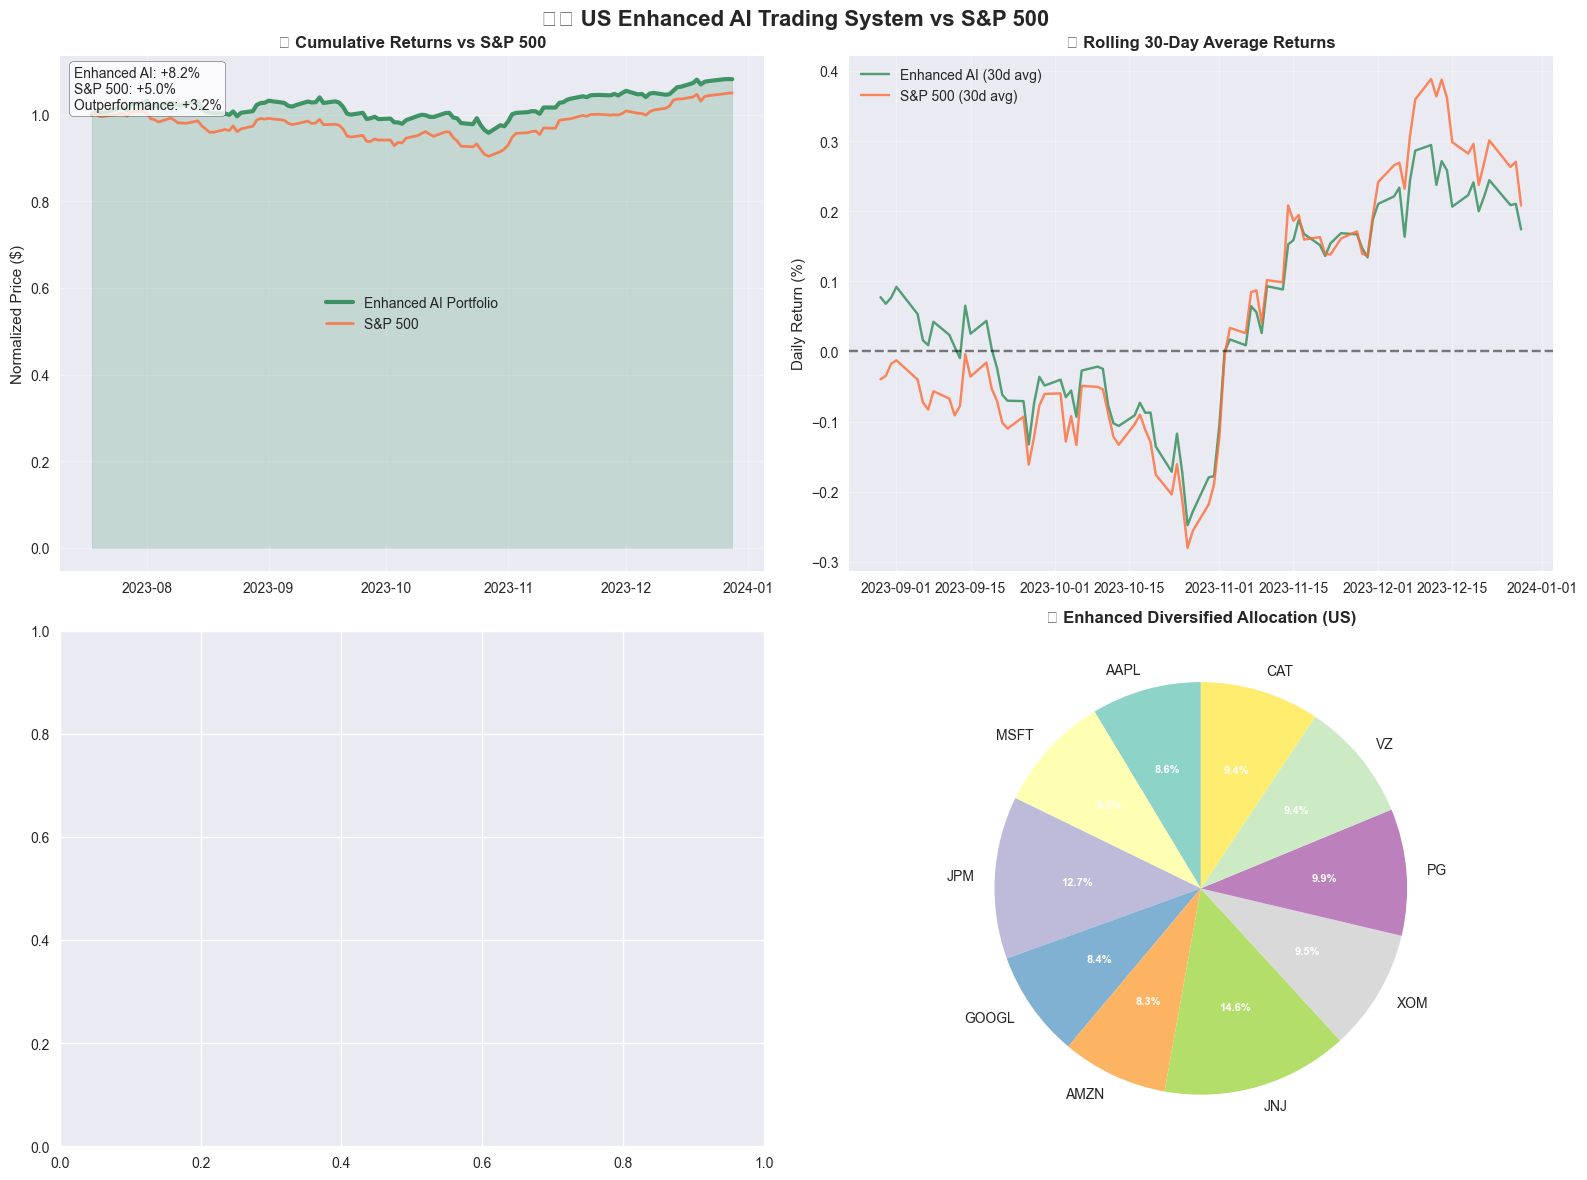


📊 ENHANCED US MARKET PERFORMANCE SUMMARY:
📈 Enhanced AI Portfolio: +8.20%
📈 S&P 500: +5.01%
🚀 Outperformance: +3.19%
📉 Max Drawdown - Enhanced AI: 7.86%
📉 Max Drawdown - S&P 500: 10.28%
📊 Volatility - Enhanced AI: 11.12%
📊 Volatility - S&P 500: 11.86%
💱 Currency: $
🌍 Market: US

✅ Enhanced Universal US Trading Experiment Complete!
🎯 Critical Improvements Applied:
   ✅ Diversification constraints (max 25.0% per asset)
   ✅ Threshold-based rebalancing (2.5% trigger)
   ✅ Enhanced reward function with benchmark tracking
   ✅ Multi-timeframe feature engineering
   ✅ Market timing layer
   ✅ Enhanced Kelly position sizing
   ✅ Reduced transaction costs through smart rebalancing
🔍 Validation: Testing performed on real data only
Memory: 79.8% used (2.0GB / 8.0GB)

🇺🇸 FINAL ENHANCED US RESULTS:
🧬 DDPM Enhanced: ✅ Yes
📚 Training Data: 3602 samples
🔍 Test Data: 200 samples (Real Only)
📈 Enhanced AI Portfolio: 9.02%
📊 Benchmark: 5.01%
🚀 Outperformance: +4.00%
📊 Sharpe Ratio: 1.622
📉 Max Drawdown

In [ ]:
if __name__ == "__main__":
    print("Enhanced Universal AI Trading System")
    print("=" * 60)
    print("Configuration:")
    print(f"  Stocks: {len(SELECTED_TICKERS)} assets")
    print(f"  Benchmark: {BENCHMARK_INDEX}")
    print(f"  Period: {START_DATE} to {END_DATE}")
    print("Enabled Features:")
    print("  - Diversification constraints")
    print("  - Threshold-based rebalancing")
    print("  - Benchmark-aware reward function")
    print("  - Market regime detection")
    print("  - Kelly sizing and market timing")
    print("  - Synthetic data generation via DDPM")
    print("  - Reduced transaction costs")
    print("=" * 60)
    results = run_enhanced_trading_experiment()

    print("\nFinal Results:")
    print("=" * 60)
    print(f"Enhanced Portfolio Return: {results['portfolio_return']:.2f}%")
    print(f"Benchmark Return: {results['benchmark_return']:.2f}%")
    print(f"Outperformance: {results['outperformance']:+.2f}%")
    print(f"Sharpe Ratio: {results['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2f}%")
    print(f"Transaction Costs: {results['total_transaction_costs']:.3f}%")
    print(f"Final Portfolio Value: {results['final_portfolio_value']:.4f}")
    print("=" * 60)